In [93]:
import numpy as np
from bs4 import BeautifulSoup
import os
import matplotlib
from unittest import TestCase
import sqlalchemy
import pyodbc
import seaborn as sns
from sqlalchemy import create_engine
matplotlib.style.use('ggplot')
sns.set(font_scale=0.5)
import pandas as pd
import matplotlib.pyplot as plot
from pylab import savefig
import pyodbc
from scipy.spatial.distance import seuclidean
from scipy.spatial.distance import cdist
import scipy
import time
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MultiLabelBinarizer, Normalizer, RobustScaler

import warnings
warnings.filterwarnings('ignore')
from matplotlib import cm
from descartes import PolygonPatch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.cluster import MiniBatchKMeans

from sklearn.model_selection import learning_curve
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import cross_validate

import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split

In [4]:
data = pd.read_csv('C:/Users/eleni.tziaferi/Desktop/grocery_data/order_products__train.csv')
orders = pd.read_csv('C:/Users/eleni.tziaferi/Desktop/grocery_data/orders.csv')

In [5]:
df = pd.merge(orders, data, how='left', on='order_id')
df = df.groupby(['user_id', 'order_id']).agg({'eval_set':'first', 'order_number':'max', 'order_dow':'max',
                                              'order_hour_of_day':'mean', 'days_since_prior_order':'mean', 
                                              'product_id':'count','add_to_cart_order':'count',  'reordered':'sum' }).fillna(0)

In [21]:
grouped = (df.reset_index()).groupby(['user_id']).agg({'order_id':'count', 'order_number':'max', 'order_dow':'max',
                                                            'order_hour_of_day':'mean', 'days_since_prior_order':'mean',
                                                            'product_id':'sum', 'add_to_cart_order':'sum',  'reordered':'mean'}).reset_index()

In [22]:
group_by_user = grouped.drop(['user_id', 'order_number', 'add_to_cart_order', 'product_id'], axis=1, errors='ignore')

In [23]:
# le = LabelEncoder()
# from sklearn.preprocessing import LabelBinarizer
# binarizer = LabelBinarizer()

# for cat in ['BikeID', 'mapped_pairs_origin_destination_stations']:
#     corr_matrix[cat] = le.fit_transform(corr_matrix[cat])
#     test[categorical] = le.fit_transform(test[categorical])
# for binary in ['weekday', 'is_weekend']:
#     corr_matrix[binary] = binarizer.fit_transform(corr_matrix[binary])
#     test[binary] = binarizer.fit_transform(test[binary])

In [24]:
col_names = group_by_user.columns
features = group_by_user[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features = group_by_user.copy()
scaled_features[col_names] = features

In [95]:
scaled_group_by_user = scaled_features[:12000]

In [96]:
X = scaled_group_by_user.select_dtypes(include=[np.number])
X = X.drop(['days_since_prior_order'], axis=1)
# y = np.log1p(corr_matrix['Duration_Mins'])
y = scaled_group_by_user['days_since_prior_order']

In [97]:
X_train, x_test, Y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
train = xgb.DMatrix(X_train, label=Y_train)
test = xgb.DMatrix(x_test, label=y_test)
watchlist = [(train, 'train'), (test, 'test')]

In [98]:
params = {}
params["objective"] = "reg:linear"
params["eta"] = 0.1
params["min_child_weight"] = 30
params["subsample"] = 0.8
params["colsample_bytree"] = 0.3
params["scale_pos_weight"] = 1.0
params["silent"] = 1
params["max_depth"] = 10
params["nthread"] = -1

plst = list(params.items())

In [99]:
model_xgb = xgb.train(plst, train, 500, watchlist, early_stopping_rounds=10, maximize=False, verbose_eval=20)
print('Modeling RMSLE %.5f' % model_xgb.best_score)

[0]	train-rmse:1.07805	test-rmse:1.05248
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 10 rounds.
[20]	train-rmse:0.873449	test-rmse:0.865082
[40]	train-rmse:0.849741	test-rmse:0.848685
[60]	train-rmse:0.829981	test-rmse:0.833531
[80]	train-rmse:0.824857	test-rmse:0.83021
Stopping. Best iteration:
[80]	train-rmse:0.824857	test-rmse:0.83021

Modeling RMSLE 0.83021


In [100]:
xgb_pars = {'objective': 'reg:linear', 'eta': 0.3,'min_child_weight': 17, 'subsample': 0.9,'colsample_bytree': 1.0, 
            'max_depth': 3, 'lambda': 2., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,'eval_metric': 'rmse',
            'objective': 'reg:linear'}

model = xgb.train(xgb_pars, train, 500, watchlist, early_stopping_rounds=10,maximize=False, verbose_eval=20)
print('Modeling RMSLE %.5f' % model.best_score)

[0]	train-rmse:0.991106	test-rmse:0.969794
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 10 rounds.
[20]	train-rmse:0.826943	test-rmse:0.820161
Stopping. Best iteration:
[18]	train-rmse:0.82812	test-rmse:0.820001

Modeling RMSLE 0.82000


In [101]:
import matplotlib.pyplot as plt

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) 

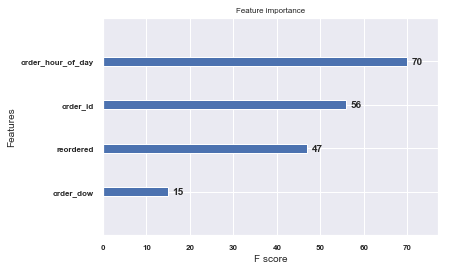

In [102]:
%matplotlib inline

xgb.plot_importance(model)

In [103]:
print('score = %1.5f, n_boost_round =%d.'%(model_xgb.best_score,model_xgb.best_iteration))

score = 0.83021, n_boost_round =80.


In [104]:
ypredict = model.predict(test)

In [105]:
ypredict

array([ 0.48124832,  0.36479884, -0.11098135, ...,  0.3628182 ,
        0.43816432,  0.2847517 ], dtype=float32)

In [106]:
labels = test.get_label()
print('test deviance=%f' % (2 * np.sum((labels - ypredict) / ypredict - labels + ypredict)))

test deviance=660.075562


In [107]:
print('start testing prediction from first n trees')
### predict using first 1 tree
ypred1 = model.predict(test, ntree_limit=1)
# by default, we predict using all the trees
ypred2 = model.predict(test)
print('error of ypred1=%f' % (np.sum((ypred1 > 0.5) != labels) / float(len(labels))))
print('error of ypred2=%f' % (np.sum((ypred2 > 0.5) != labels) / float(len(labels))))

start testing prediction from first n trees
error of ypred1=1.000000
error of ypred2=1.000000


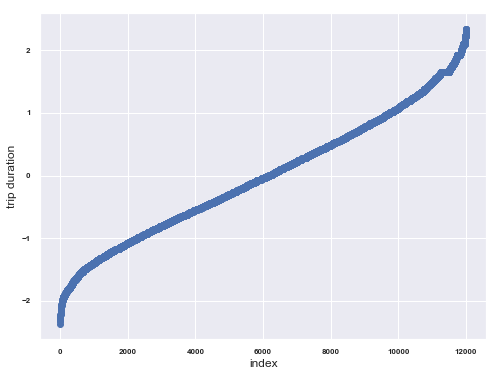

In [108]:
plt.figure(figsize=(8,6))
plt.scatter(range(scaled_group_by_user.shape[0]), np.sort(scaled_group_by_user.days_since_prior_order.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('trip duration', fontsize=12)
plt.show()

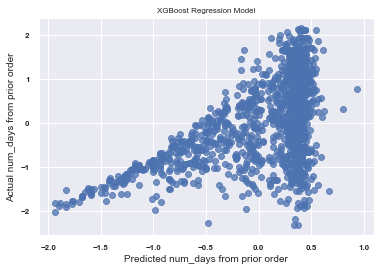

In [109]:
actual_values = y_test
plt.scatter(ypredict, actual_values, alpha=.75,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Predicted num_days from prior order')
plt.ylabel('Actual num_days from prior order')
plt.title('XGBoost Regression Model')
plt.show()

In [116]:
Xtrain, xtest, Ytrain, ytest = sklearn.model_selection.train_test_split(X, y, test_size=0.1, random_state=0)

In [117]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 1.0, learning_rate = 0.1,
                max_depth = 9, alpha = 10, n_estimators = 10, min_child_weight = 5)

In [118]:
xg_reg.fit(Xtrain,Ytrain)

preds = xg_reg.predict(xtest)

[16:49:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [119]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.859578


In [120]:
params = {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,6)],
          'subsample':[i/10.0 for i in range(4,11)], 
          'colsample_bytree':[i for i in range(0,1)],
          'max_depth':[ i for i in range(4,12)]}

In [ ]:
xgb1 = xgb.XGBRegressor(nthread=1) 
grid1 = GridSearchCV(xgb1, params)
grid1.fit(X, y)

[16:52:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:42] WARNI

[16:53:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:53:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:53:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:53:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:53:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:53:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:53:03] WARNI

[16:53:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:53:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:53:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:53:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:53:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:53:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:53:26] WARNI

[16:53:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:53:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:53:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:53:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:53:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:53:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:53:51] WARNI

[16:54:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:54:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:54:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:54:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:54:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:54:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:54:17] WARNI

[16:54:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:54:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:54:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:54:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:54:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:54:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:54:45] WARNI